In [26]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import os
import re
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  Concatenate, Input, BatchNormalization
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121 
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unzipping the folder


!unzip '/content/drive/MyDrive/MURA-v1.1.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/XR_WRIST/patient08489/study1_negative/image3.png  
  inflating: train/XR_WRIST/patient08489/study1_negative/image4.png  
  inflating: train/XR_WRIST/patient08490/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient08490/study1_negative/image2.png  
  inflating: train/XR_WRIST/patient08490/study1_negative/image3.png  
  inflating: train/XR_WRIST/patient08491/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient08491/study1_negative/image2.png  
  inflating: train/XR_WRIST/patient08492/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient08492/study1_negative/image2.png  
  inflating: train/XR_WRIST/patient08493/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient08493/study1_negative/image2.png  
  inflating: train/XR_WRIST/patient08493/study1_negative/image3.png  
  inflating: train/XR_WRIST/patient08494/study1_negative/image1.png  
  inflating: train/XR_WRIST/patient0849

In [4]:
# Importing Data
train_path = pd.read_csv('/content/train_image_paths.csv', header=None, names=['paths'])
valid_path = pd.read_csv('/content/valid_image_paths.csv', header=None, names=['paths'])

In [5]:
# Changing filename according to its present filepath.

pattern = 'MURA-v1.1'
replace = '/content'
path = []
for i in train_path['paths']:
    res = re.sub (pattern, replace,i)
    path.append(res)
len(path)

36808

In [6]:
# Adding path column to train_path dataframe and droping old 'paths' column.
train_path['path'] = path
train_path.head()


,paths,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,/content/train/XR_SHOULDER/patient00001/study1...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,/content/train/XR_SHOULDER/patient00001/study1...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,/content/train/XR_SHOULDER/patient00001/study1...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,/content/train/XR_SHOULDER/patient00002/study1...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,/content/train/XR_SHOULDER/patient00002/study1...


In [7]:
# Droping old 'paths' column from dataframe

train_path.drop('paths', axis=1, inplace= True)
train_path.head()

,path
0,/content/train/XR_SHOULDER/patient00001/study1...
1,/content/train/XR_SHOULDER/patient00001/study1...
2,/content/train/XR_SHOULDER/patient00001/study1...
3,/content/train/XR_SHOULDER/patient00002/study1...
4,/content/train/XR_SHOULDER/patient00002/study1...


In [8]:
# Creating new column with the help of path column.

result = []
for i in train_path ['path']:
  res_1 = re.findall('positive', i)
  res_0 = re.findall('negative', i)
  result.extend(res_1)
  result.extend(res_0)

In [9]:
train_path['result']=result
train_path.head()

,path,result
0,/content/train/XR_SHOULDER/patient00001/study1...,positive
1,/content/train/XR_SHOULDER/patient00001/study1...,positive
2,/content/train/XR_SHOULDER/patient00001/study1...,positive
3,/content/train/XR_SHOULDER/patient00002/study1...,positive
4,/content/train/XR_SHOULDER/patient00002/study1...,positive


In [10]:
# Changing the filename according to its present filepath

pattern = 'MURA-v1.1'
replace = '/content'
path = []
for i in valid_path['paths']:
  res = re.sub(pattern, replace, i)
  path.append(res)
len(path)

3197

In [11]:
# Adding path column to valid_path dataframe.
valid_path['path'] = path
valid_path.head()


,paths,path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,/content/valid/XR_WRIST/patient11185/study1_po...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,/content/valid/XR_WRIST/patient11185/study1_po...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,/content/valid/XR_WRIST/patient11185/study1_po...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,/content/valid/XR_WRIST/patient11185/study1_po...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,/content/valid/XR_WRIST/patient11186/study1_po...


In [12]:
# Droping old 'paths' column from dataframe.
valid_path.drop('paths',axis=1,inplace=True)
valid_path.head()

,path
0,/content/valid/XR_WRIST/patient11185/study1_po...
1,/content/valid/XR_WRIST/patient11185/study1_po...
2,/content/valid/XR_WRIST/patient11185/study1_po...
3,/content/valid/XR_WRIST/patient11185/study1_po...
4,/content/valid/XR_WRIST/patient11186/study1_po...


In [13]:
# Creating new column with the help of path column.

result = []
for i in valid_path ['path']:
  res_1 = re.findall('positive', i)
  res_0 = re.findall('negative', i)
  result.extend(res_1)
  result.extend(res_0)

In [14]:
valid_path['result']=result
valid_path.head()

,path,result
0,/content/valid/XR_WRIST/patient11185/study1_po...,positive
1,/content/valid/XR_WRIST/patient11185/study1_po...,positive
2,/content/valid/XR_WRIST/patient11185/study1_po...,positive
3,/content/valid/XR_WRIST/patient11185/study1_po...,positive
4,/content/valid/XR_WRIST/patient11186/study1_po...,positive


**Inception v3**

**Data Preprocessing**

In [15]:
inc_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
inc_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# inc_train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# inc_test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [16]:
inc_train_set = inc_train_datagen.flow_from_dataframe(train_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)
inc_valid_set = inc_test_datagen.flow_from_dataframe(valid_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)


Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
inc_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [ ]:
for layer in inc_model.layers:
  layer.trainable = False

In [ ]:
x_inc = inc_model.output
x_inc = Flatten()(x_inc)
#x_inc= BatchNormalization()(x_inc)
#x_inc= Dropout(0.4)(x_inc)
x_inc = Dense(1024, activation='relu')(x_inc)
#x_inc= Dense(512,activation='relu')(x_inc)
#x_inc= BatchNormalization()(x_inc)
x_inc = Dropout(0.4)(x_inc)
output = Dense(1,activation='sigmoid')(x_inc)
model_incep = Model(inputs=inc_model.input, outputs=output)


In [ ]:
model_incep.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model_incep.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
history = model_incep.fit(inc_train_set, validation_data=inc_valid_set, shuffle=True, epochs=15, batch_size=256)

Epoch 1/15
1151/1151 [==============================] - 195s 166ms/step - loss: 2.8936 - accuracy: 0.6460 - val_loss: 0.5822 - val_accuracy: 0.6875
Epoch 2/15
1151/1151 [==============================] - 180s 157ms/step - loss: 0.5828 - accuracy: 0.7008 - val_loss: 0.5743 - val_accuracy: 0.6797
Epoch 3/15
1151/1151 [==============================] - 184s 160ms/step - loss: 0.5563 - accuracy: 0.7187 - val_loss: 0.5811 - val_accuracy: 0.6897
Epoch 4/15
1151/1151 [==============================] - 189s 164ms/step - loss: 0.5343 - accuracy: 0.7339 - val_loss: 0.5769 - val_accuracy: 0.6784
Epoch 5/15
1151/1151 [==============================] - 190s 165ms/step - loss: 0.5118 - accuracy: 0.7474 - val_loss: 0.6144 - val_accuracy: 0.6534
Epoch 6/15
1151/1151 [==============================] - 190s 165ms/step - loss: 0.4939 - accuracy: 0.7558 - val_loss: 0.5621 - val_accuracy: 0.6938
Epoch 7/15
1151/1151 [==============================] - 191s 166ms/step - loss: 0.4811 - accuracy: 0.7647 - val_

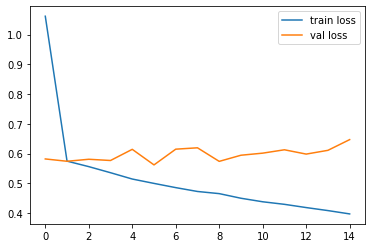

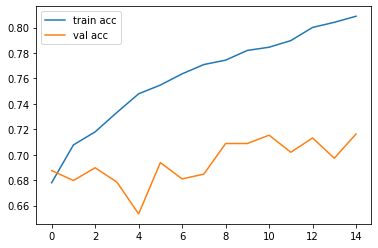

In [ ]:
#loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

**ResNet50**

**Data Preprocessing**

In [17]:
rsnt_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
rsnt_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
rsnt_train_set = rsnt_train_datagen.flow_from_dataframe(train_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)


Found 36808 validated image filenames belonging to 2 classes.


In [19]:
rsnt_valid_set = rsnt_test_datagen.flow_from_dataframe (valid_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)


Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
rsnt_model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in rsnt_model.layers:
  layer.trainable = False

In [ ]:
x_rsnt = rsnt_model.output
x_rsnt = Flatten()(x_rsnt)
x_rsnt = Dense(1024, activation='relu')(x_rsnt)
x_rsnt= BatchNormalization()(x_rsnt)
x_rsnt = Dropout(0.3)(x_rsnt)
output = Dense(1,activation='sigmoid')(x_rsnt)
model_res = Model(inputs = rsnt_model.input, outputs = output)



In [ ]:
model_res.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model_res.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = model_res.fit(rsnt_train_set,epochs=10,shuffle=True,validation_data=rsnt_valid_set, batch_size=256)

Epoch 1/10
1151/1151 [==============================] - 216s 184ms/step - loss: 0.6959 - accuracy: 0.6978 - val_loss: 0.6219 - val_accuracy: 0.6997
Epoch 2/10
1151/1151 [==============================] - 229s 199ms/step - loss: 0.4524 - accuracy: 0.7902 - val_loss: 0.5583 - val_accuracy: 0.7382
Epoch 3/10
1151/1151 [==============================] - 208s 180ms/step - loss: 0.3894 - accuracy: 0.8302 - val_loss: 0.5611 - val_accuracy: 0.7388
Epoch 4/10
1151/1151 [==============================] - 210s 183ms/step - loss: 0.3280 - accuracy: 0.8591 - val_loss: 0.6093 - val_accuracy: 0.7416
Epoch 5/10
1151/1151 [==============================] - 220s 191ms/step - loss: 0.2732 - accuracy: 0.8851 - val_loss: 0.6558 - val_accuracy: 0.7272
Epoch 6/10
1151/1151 [==============================] - 223s 194ms/step - loss: 0.2338 - accuracy: 0.9042 - val_loss: 0.7164 - val_accuracy: 0.7354
Epoch 7/10
1151/1151 [==============================] - 228s 198ms/step - loss: 0.1898 - accuracy: 0.9244 - val_

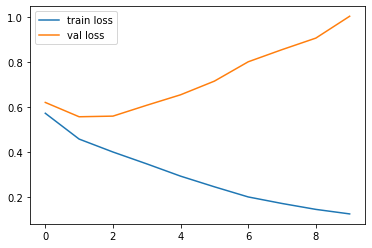

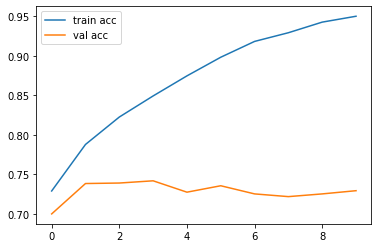

In [ ]:
#loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

**VGG-16**

**Data Preprocessing**

In [20]:
# vgg_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# vgg_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
vgg_train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

vgg_test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [21]:
vgg_train_set = vgg_train_datagen.flow_from_dataframe(train_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)
vgg_valid_set = vgg_test_datagen.flow_from_dataframe(valid_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)


Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
x_vgg = vgg_model.output
x_vgg = Flatten()(x_vgg)
#x_inc= BatchNormalization()(x_inc)
#x_inc= Dropout(0.4)(x_inc)
x_vgg = Dense(1024, activation='relu')(x_vgg)
#x_inc= Dense(512,activation='relu')(x_inc)
#x_inc= BatchNormalization()(x_inc)
x_vgg = Dropout(0.4)(x_vgg)
output = Dense(1,activation='sigmoid')(x_vgg)
model_vgg = Model(inputs=vgg_model.input, outputs=output)


In [ ]:
model_vgg.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
history = model_vgg.fit(vgg_train_set,epochs=15,shuffle=True,validation_data=vgg_valid_set, batch_size=256)

Epoch 1/15
1151/1151 [==============================] - 193s 168ms/step - loss: 0.4520 - accuracy: 0.7709 - val_loss: 0.5566 - val_accuracy: 0.7244
Epoch 2/15
1151/1151 [==============================] - 192s 167ms/step - loss: 0.4441 - accuracy: 0.7780 - val_loss: 0.5599 - val_accuracy: 0.7107
Epoch 3/15
1151/1151 [==============================] - 190s 165ms/step - loss: 0.4384 - accuracy: 0.7805 - val_loss: 0.6085 - val_accuracy: 0.7116
Epoch 4/15
1151/1151 [==============================] - 190s 165ms/step - loss: 0.4277 - accuracy: 0.7880 - val_loss: 0.6474 - val_accuracy: 0.7169
Epoch 5/15
1151/1151 [==============================] - 190s 165ms/step - loss: 0.4194 - accuracy: 0.7897 - val_loss: 0.6002 - val_accuracy: 0.7285
Epoch 6/15
1151/1151 [==============================] - 190s 165ms/step - loss: 0.4182 - accuracy: 0.7850 - val_loss: 0.5801 - val_accuracy: 0.7175
Epoch 7/15
1151/1151 [==============================] - 189s 164ms/step - loss: 0.4145 - accuracy: 0.7915 - val_

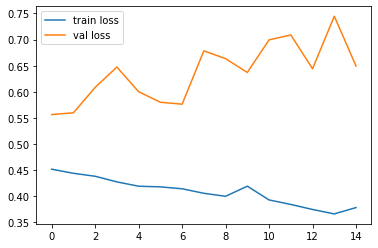

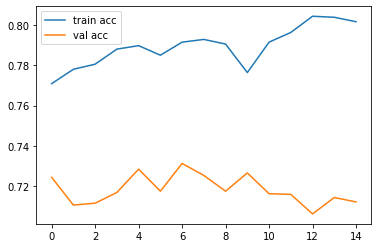

In [ ]:
#loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

**DenseNet**

**Data Preprocessing**

In [22]:
den_train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

den_test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [23]:
den_train_set = den_train_datagen.flow_from_dataframe(train_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)
den_valid_set = den_test_datagen.flow_from_dataframe(valid_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)


Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
den_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3))

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
for layer in den_model.layers:
  layer.trainable = False

In [ ]:
x_den = den_model.output
x_den = Flatten()(x_den)
#x_den= BatchNormalization()(x_den)
#x_den= Dropout(0.4)(x_den)
x_den = Dense(1024, activation='relu')(x_den)
#x_den= Dense(512,activation='relu')(x_den)
#x_den= BatchNormalization()(x_den)
x_den = Dropout(0.4)(x_den)
output = Dense(1,activation='sigmoid')(x_den)
model_den = Model(inputs=den_model.input, outputs=output)

In [ ]:
model_den.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model_den.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
history = model_den.fit(den_train_set,epochs=10,shuffle=True,validation_data=den_valid_set, batch_size=256)

Epoch 1/10
1151/1151 [==============================] - 525s 450ms/step - loss: 2.5306 - accuracy: 0.6231 - val_loss: 0.5997 - val_accuracy: 0.6769
Epoch 2/10
1151/1151 [==============================] - 515s 448ms/step - loss: 0.6079 - accuracy: 0.6771 - val_loss: 0.5846 - val_accuracy: 0.6678
Epoch 3/10
1151/1151 [==============================] - 513s 446ms/step - loss: 0.6005 - accuracy: 0.6769 - val_loss: 0.5862 - val_accuracy: 0.6662
Epoch 4/10
1151/1151 [==============================] - 522s 453ms/step - loss: 0.5964 - accuracy: 0.6805 - val_loss: 0.6278 - val_accuracy: 0.6262
Epoch 5/10
1151/1151 [==============================] - 526s 457ms/step - loss: 0.5958 - accuracy: 0.6797 - val_loss: 0.5800 - val_accuracy: 0.6838
Epoch 6/10
1151/1151 [==============================] - 525s 456ms/step - loss: 0.5896 - accuracy: 0.6898 - val_loss: 0.6335 - val_accuracy: 0.6365
Epoch 7/10
1151/1151 [==============================] - 526s 457ms/step - loss: 0.5888 - accuracy: 0.6843 - val_

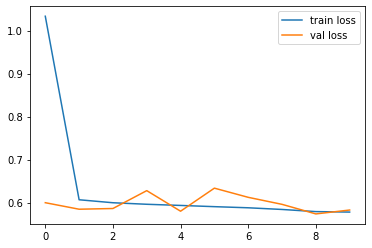

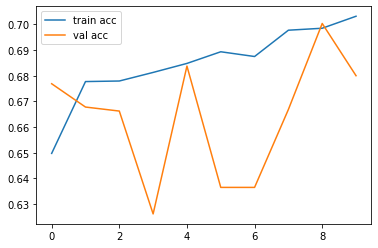

In [ ]:
#loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

**Saving The Models**

In [ ]:
model_incep.save('/content/drive/MyDrive/best_incp_scr.h5')

In [ ]:
model_res.save('/content/drive/MyDrive/best_rsnt_scr.h5')

In [ ]:
model_vgg.save('/content/drive/MyDrive/best_vgg16_scr.h5')

In [ ]:
model_den.save('/content/drive/MyDrive/best_den_scr.h5')

**Ensemble Model**

In [ ]:
# Loading Models

model1 =load_model('/content/drive/MyDrive/best_incp_scr.h5')
model2 =load_model('/content/drive/MyDrive/best_vgg16_scr.h5')
model3 =load_model('/content/drive/MyDrive/best_den_scr.h5')

In [24]:
# essm_train_datagen = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2,
#                                    vertical_flip=True, horizontal_flip=True)
# essm_valid_datagen = ImageDataGenerator(rescale=1/255)
essm_train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   preprocessing_function=preprocess_input,)

essm_valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   preprocessing_function=preprocess_input,)

In [25]:
essm_train_set = essm_train_datagen.flow_from_dataframe(train_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)
essm_valid_set = essm_valid_datagen.flow_from_dataframe(valid_path,
                                              x_col='path',
                                              y_col='result',
                                              target_size=(224, 224), 
                                              class_mode='binary',
                                              batch_size=32,
                                              color_mode='rgb',
                                              shuffle=True)

Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
inputs = Input(shape=(224,224,3))
combined = Concatenate()([model1(inputs), model2(inputs), model3(inputs)])
outputs = Dense(1,activation='sigmoid')(combined)

model4 = Model(inputs, outputs)
model1.trainable = False
model2.trainable = False
model3.trainable = False

In [ ]:
model4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 1)            74233633    input_1[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 1)            40406849    input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            58419777    input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
history=model4.fit(essm_train_set,epochs=10,shuffle=True,validation_data=essm_valid_set, batch_size=256)

Epoch 1/10
1151/1151 [==============================] - 993s 815ms/step - loss: 0.7049 - accuracy: 0.5854 - val_loss: 0.6575 - val_accuracy: 0.6503
Epoch 2/10
1151/1151 [==============================] - 877s 762ms/step - loss: 0.6473 - accuracy: 0.6655 - val_loss: 0.6101 - val_accuracy: 0.7050
Epoch 3/10
1151/1151 [==============================] - 880s 764ms/step - loss: 0.6163 - accuracy: 0.6840 - val_loss: 0.5838 - val_accuracy: 0.7150
Epoch 4/10
1151/1151 [==============================] - 865s 752ms/step - loss: 0.5997 - accuracy: 0.6925 - val_loss: 0.5683 - val_accuracy: 0.7188
Epoch 5/10
1151/1151 [==============================] - 856s 744ms/step - loss: 0.5878 - accuracy: 0.6974 - val_loss: 0.5560 - val_accuracy: 0.7216
Epoch 6/10
1151/1151 [==============================] - 853s 741ms/step - loss: 0.5777 - accuracy: 0.7096 - val_loss: 0.5513 - val_accuracy: 0.7219
Epoch 7/10
1151/1151 [==============================] - 841s 730ms/step - loss: 0.5776 - accuracy: 0.7047 - val_

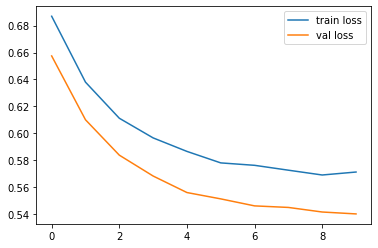

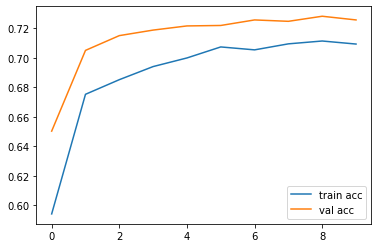

In [ ]:
#loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
model4.save('/content/drive/MyDrive/best_essm_scr.h5')

**Model Evaluation**

**Confusion Matrix**

In [28]:
# Loding Models
model_in =load_model('/content/drive/MyDrive/MURA/best_incp_scr.h5')
model_vg =load_model('/content/drive/MyDrive/MURA/best_vgg16_scr.h5')
model_re =load_model('/content/drive/MyDrive/MURA/best_rsnt_scr.h5')
model_de =load_model('/content/drive/MyDrive/MURA/best_den_scr.h5')
model_es = load_model('/content/drive/MyDrive/MURA/best_essm_scr.h5')

**InceptionV3**

In [36]:
Y_pred_in = model_in.predict(inc_valid_set)
df = Y_pred_in

decision_teshold = 0.5
in_predict =[]

for i in df:
    if i<decision_teshold:
        in_predict.append(0)
    else:
        in_predict.append(1)

print('Confusion Matrix InceptionV3 Model \n')
cf_matrix = (confusion_matrix(inc_valid_set.classes, in_predict))
print(cf_matrix)

Confusion Matrix InceptionV3 Model 

[[1618   49]
 [1485   45]]


In [37]:
print('Classification Report InceptionV3 Model \n')
target_names = ['Negative', 'Positive']
print(classification_report(inc_valid_set.classes, in_predict, target_names=target_names))


Classification Report InceptionV3 Model 

              precision    recall  f1-score   support

    Negative       0.52      0.97      0.68      1667
    Positive       0.48      0.03      0.06      1530

    accuracy                           0.52      3197
   macro avg       0.50      0.50      0.37      3197
weighted avg       0.50      0.52      0.38      3197



**Ensemmble**

In [38]:
Y_pred = model_es.predict(essm_valid_set)
df = Y_pred
decision_teshold = 0.5
es_predict =[]

for i in df:
    if i<decision_teshold:
        es_predict.append(0)
    else:
        es_predict.append(1)
        
print('Confusion Matrix Ensemmble Model \n')
cf_matrix = (confusion_matrix(essm_valid_set.classes, es_predict))
print(cf_matrix)

Confusion Matrix Ensemmble Model 

[[1160  507]
 [1065  465]]


**vgg16**

In [39]:
#Confution Matrix 
Y_pred_vg = model_vg.predict(vgg_valid_set)
df = Y_pred_vg
decision_teshold = 0.5
vg_predict =[]

for i in df:
    if i<decision_teshold:
        vg_predict.append(0)
    else:
        vg_predict.append(1)
print('Confusion Matrix vgg16 Model \n')
cf_matrix = (confusion_matrix(vgg_valid_set.classes, vg_predict))
print(cf_matrix)

Confusion Matrix vgg16 Model 

[[1122  545]
 [1046  484]]


**ResNet**

In [40]:
Y_pred_re = model_re.predict(rsnt_valid_set)
df = Y_pred_re

decision_teshold = 0.5
re_predict =[]

for i in df:
    if i<decision_teshold:
        re_predict.append(0)
    else:
        re_predict.append(1)

print('Confusion Matrix ResNet Model \n')
cf_matrix = (confusion_matrix(rsnt_valid_set.classes, re_predict))
print(cf_matrix)

Confusion Matrix ResNet Model 

[[971 696]
 [954 576]]


**DenseNet**

In [41]:
Y_pred_de = model_de.predict(den_valid_set)
df = Y_pred_de

decision_teshold = 0.5
de_predict =[]

for i in df:
    if i<decision_teshold:
        de_predict.append(0)
    else:
        de_predict.append(1)

print('Confusion Matrix DenseNet Model \n')
cf_matrix = (confusion_matrix(den_valid_set.classes, de_predict))
print(cf_matrix)

Confusion Matrix DenseNet Model 

[[1307  360]
 [1221  309]]


**Prediction**

In [42]:
import tensorflow as tf
from keras_preprocessing import image
images = image.load_img("/content/train/XR_ELBOW/patient00011/study1_negative/image1.png", target_size=(224, 224))    
test_image = image.img_to_array(images)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image/255.0

In [44]:
prediction = model_vg.predict(test_image)
prediction

array([[0.40335432]], dtype=float32)

In [45]:
output = prediction[0][0]
if output>0.5:
    state='Abnornality detected'
    print(state)
else:
    state='Abnormality not detected'
    print(state)

Abnormality not detected
